# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

Download the dataset

In [ ]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
from datasets import load_dataset
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Filter row with length greater than 8.


In [ ]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


Filter:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Create a tokenizer and Detokenizer

In [ ]:
from tensorflow.keras.layers import TextVectorization

tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

Remove from corpus the sentences where any unknow word appears

In [ ]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [ ]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [ ]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [ ]:
#split the dataset
train_generator = DataGenerator(shuffled_data[:220000], batch_size=128)
test_generator = DataGenerator(shuffled_data[220000:], batch_size=256)

In [ ]:
x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")


original:  <start> many states have laws helping persons with disabilities <comma> the homeless and others to vote <end>
shuffled:  <start> to others have laws many homeless the vote and persons states <comma> disabilities with helping <end>


original:  <start> many people are also at risk because of their genetic makeup <end>
shuffled:  <start> their of makeup genetic risk also people many are because at <end>


original:  <start> winter brings snow on at least a few occasions <end>
shuffled:  <start> least winter brings few a on occasions snow at <end>


original:  <start> plant propagation can also refer to the artificial or natural dispersal of plants <end>
shuffled:  <start> the propagation or natural plants refer dispersal plant also artificial to of can <end>


original:  <start> tiger sharks are known to have a wide variety of prey <end>
shuffled:  <start> variety to wide a of prey tiger sharks are have known <end>


original:  <start> dietary protein is supplied from plant an

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [ ]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# Method

I have first trained an encoder-decoder seq2seq LSTM achiving a maximum 46% on the defined score. On the second phase, I used a variation of the same network but using bidirectional LSTM. Bidirectional LSTM processes the data in both forward and backward directions, and as expected, yields better results with achieving **47.8%** on the score with a **13M parameters** model.

A quick test with GRU shows that it's not able to converge as good as LSTM, at least in the first phases of training.

Testing out the model with 18M and 5M parameters also didn't yield better results due to over and underfitting, so 13M seems the sweet spot.

# Further Improvements

The models have been trained on Colab, and due to recourse limitations, some further improvements are not yet tested that could bring better results. Here's a list of possible improvements:

- Loss Function: for the training, `sparse_categorical_crossentropy` is used. It's important to know the loss function doesn't directly represent how good the model performs on the custom defined score. The bidirectional LSTM achieves Train Accuracy: 0.9357 and Test Accuracy: 0.8791, but there is a substantial gap between the  **47.8%** score. Testing out other loss functions such as `sequence_loss` or designing a custom loss function could yield better results.

- Transformers: Transformers capture complex dependencies and contextual relationships more effectively. They use self-attention mechanisms to weigh the importance of different parts of the input data, irrespective of their positions within the sequence. However, their complexity, potential overfitting and longer training time could make them subpar for our task.

- **Fine-tuning**: We could filter parts of the training data that the trained model gets a score below a threshhold (like 35%) and fine-tune our model based on that data. This is the most simple and promising solution, but due to limited time could not be tested.


# Defining the model

we will go one with an LSTM-based sequence-to-sequence (seq2seq) model

In [ ]:
from tensorflow.keras.layers import Input, GRU, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model


def create_encoder(vocab_size, embedding_dim, gru_units):

    encoder_inputs = Input(shape=(None,), dtype='int32', name='encoder_inputs')
    # Embedding layer
    encoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
    # LSTM layer
    encoder_outputs, state_h = LSTM(gru_units, return_state=True)(encoder_embedding)
    # The encoder model
    encoder_model = Model(encoder_inputs, [encoder_outputs, state_h])
    return encoder_model


In [ ]:
def create_decoder(vocab_size, embedding_dim, gru_units):

    decoder_inputs = Input(shape=(None,), dtype='int32', name='decoder_inputs')
    # Shared embedding layer
    decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
    # LSTM layer
    decoder_gru = LSTM(gru_units, return_sequences=True, return_state=True)
    decoder_outputs, _ = decoder_gru(decoder_embedding)
    # Dense layer to predict next word
    decoder_dense = Dense(vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    # The decoder model
    decoder_model = Model(decoder_inputs, decoder_outputs)
    return decoder_model


In [ ]:

def create_seq2seq_model(vocab_size, embedding_dim, gru_units):
    # Encoder
    encoder_inputs = Input(shape=(None,), dtype='int32', name='encoder_inputs')
    encoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
    encoder_mask = Masking()(encoder_embedding)
    encoder_outputs, state_h, state_c = LSTM(gru_units, return_state=True)(encoder_mask)  # Corrected unpacking

    # Decoder
    decoder_inputs = Input(shape=(None,), dtype='int32', name='decoder_inputs')
    decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
    decoder_mask = Masking()(decoder_embedding)
    decoder_lstm = LSTM(gru_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=[state_h, state_c])  # Provide both states
    decoder_dense = Dense(vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Seq2Seq Model
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
    return model

In [ ]:
# a custom learning rate scheduler for training
def update_learning_rate(optimizer, epoch, initial_lr=0.001, decay_factor=0.3, step_size=10):
    if (epoch + 1) % step_size == 0:
        new_lr = optimizer.learning_rate.numpy() * decay_factor
        optimizer.learning_rate.assign(new_lr)
        print(f"Updated learning rate to {new_lr}")
    else:
        print(f"Current learning rate: {optimizer.learning_rate.numpy()}")

In [ ]:
from tensorflow.keras.optimizers import Adam

vocab_size = 10000
embedding_dim = 256
gru_units = 512

model = create_seq2seq_model(vocab_size, embedding_dim, gru_units)

learning_rate = 0.001
optimizer = Adam(weight_decay=1e-4, learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 embedding (Embedding)       (None, None, 256)            2560000   ['encoder_inputs[0][0]']      
                                                                                              

# Training
We define a training loop that goes through the data batch by batch and records the metrics and returns them for later review

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import numpy as np

def train_model(model, train_generator, test_generator, text_detokenizer, epochs=10):
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
        'test_custom_score': []
    }

    best_accuracy = 0.0  # for model saving

    # Loss and Accuracy initialization
    loss_fn = SparseCategoricalCrossentropy()
    accuracy_metric = SparseCategoricalAccuracy()


    with tf.device('/GPU:0'):
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")


            train_losses = []
            train_accuracies = []

            # Training
            for i, (x_batch, y_batch) in enumerate(train_generator):
                loss, acc = model.train_on_batch([x_batch, y_batch[:, :-1]], y_batch[:, 1:])
                train_losses.append(loss)
                train_accuracies.append(acc)

                if i % 500 == 499:
                    print(f"  Batch {i+1}/{len(train_generator)} - Loss: {loss:.4f}, Accuracy: {acc:.4f}")

            # Update learning rate
            # update_learning_rate(optimizer, epoch)

            # record average training loss and accuracy for the epoch
            epoch_train_loss = np.mean(train_losses)
            epoch_train_acc = np.mean(train_accuracies)
            history['train_loss'].append(epoch_train_loss)
            history['train_accuracy'].append(epoch_train_acc)

            # manual Evaluation and custom score calculation after each epoch
            test_losses = []
            test_accuracies = []
            pred_sentences = []
            true_sentences = []

            # reset the accuracy metric at the start of each epoch
            accuracy_metric.reset_states()

            for x_batch, y_batch in test_generator:
                y_true = y_batch[:, 1:]
                preds = model.predict([x_batch, y_batch[:, :-1]], verbose=0)

                # Loss
                loss = loss_fn(y_true, preds).numpy()
                test_losses.append(loss)

                # Accuracy
                accuracy_metric.update_state(y_true, preds)
                test_accuracies.append(accuracy_metric.result().numpy())

                # Custom score
                pred_sentences.extend(text_detokenizer(preds.argmax(-1)))
                true_sentences.extend(text_detokenizer(y_true))

            #  averaging over all batches
            epoch_test_loss = np.mean(test_losses)
            epoch_test_accuracy = np.mean(test_accuracies)
            history['test_loss'].append(epoch_test_loss)
            history['test_accuracy'].append(epoch_test_accuracy)

            # calculate the mean of custom scores
            scores = [score(true, pred) for true, pred in zip(true_sentences, pred_sentences)]
            mean_score = np.mean(scores)
            history['test_custom_score'].append(mean_score)

            # save model if it improves
            if mean_score > best_accuracy:
                best_accuracy = mean_score
                model.save(f'best_model_{epoch+1:03d}_{mean_score:.4f}.h5')
                print(f"New best model saved at epoch {epoch+1} with test accuracy {epoch_test_accuracy:.4f}")

            print(f"Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}, Epoch Custom Score: {mean_score:.4f}")

        return history


In [ ]:
history = train_model(model, train_generator, test_generator,
                      detokenizer, epochs=15)

Epoch 1/15
  Batch 500/1718 - Loss: 2.7400, Accuracy: 0.6137
  Batch 1000/1718 - Loss: 2.4049, Accuracy: 0.6496
  Batch 1500/1718 - Loss: 2.2274, Accuracy: 0.6719
Current learning rate: 0.0010000000474974513


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved at epoch 1 with test accuracy 0.6726
Epoch 1: Train Loss: 2.6342, Train Accuracy: 0.6283, Test Loss: 2.2081, Test Accuracy: 0.6726, Epoch Custom Score: 0.1243
Epoch 2/15
  Batch 500/1718 - Loss: 2.0257, Accuracy: 0.6846
  Batch 1000/1718 - Loss: 1.7776, Accuracy: 0.7095
  Batch 1500/1718 - Loss: 1.6342, Accuracy: 0.7295
Current learning rate: 0.0010000000474974513
New best model saved at epoch 2 with test accuracy 0.7314
Epoch 2: Train Loss: 1.8974, Train Accuracy: 0.7018, Test Loss: 1.6123, Test Accuracy: 0.7314, Epoch Custom Score: 0.1885
Epoch 3/15
  Batch 500/1718 - Loss: 1.4245, Accuracy: 0.7549
  Batch 1000/1718 - Loss: 1.2370, Accuracy: 0.7717
  Batch 1500/1718 - Loss: 1.1326, Accuracy: 0.7905
Current learning rate: 0.0010000000474974513
New best model saved at epoch 3 with test accuracy 0.7841
Epoch 3: Train Loss: 1.3338, Train Accuracy: 0.7613, Test Loss: 1.1579, Test Accuracy: 0.7841, Epoch Custom Score: 0.2721
Epoch 4/15
  Batch 500/1718 - Loss: 0.9926, 

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):

  train_acc = history['train_accuracy']
  test_acc = history['test_accuracy']
  test_custom_score = history['test_custom_score']

  # the number of epochs based on the length of metric list
  epochs = range(1, len(train_acc) + 1)

  # create a plot
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_acc, 'b', label='Training Accuracy', color='blue')  # Training Accuracy in blue
  plt.plot(epochs, test_acc, 'b', label='Test Accuracy', color='green')  # Test Accuracy in green
  plt.plot(epochs, test_custom_score, 'b', label='Test Custom Score', color='red')  # Custom Score in red

  plt.title('Training and Test Accuracy vs. Test Custom Score')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy/Score')
  plt.legend()

  plt.show()

<ipython-input-22-bd6936485fbe>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train_acc, 'b', label='Training Accuracy', color='blue')  # Training Accuracy in blue
<ipython-input-22-bd6936485fbe>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, test_acc, 'b', label='Test Accuracy', color='green')  # Test Accuracy in green
<ipython-input-22-bd6936485fbe>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, test_custom_score, 'b', label='Test Custom Score', color='red')  # Custom Score in red


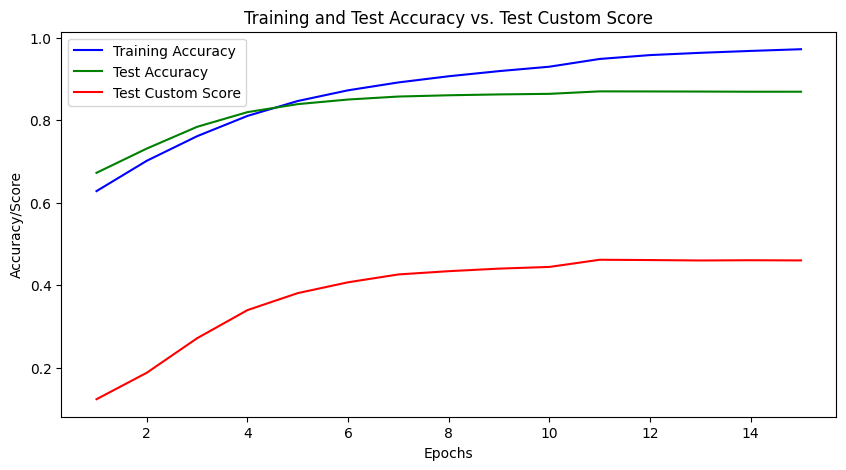

In [ ]:
plot_history(history)

## The best model: Bidirectional LSTM
Now we will test out and compare a variation of LSTMs called bidirectional LSTM that look at future tokens as well as previous ones, theoretically better for our task.

In [ ]:

def build_model(vocab_size, embed_dim, units, dropout_rate=0.2):

    encoder_inputs = tf.keras.Input(shape=(None,))
    decoder_inputs = tf.keras.Input(shape=(None,))

    # Embeddings
    encoder_embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)(encoder_inputs)
    decoder_embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)(decoder_inputs)

    # Encoder with Dropout and Bidirectional LSTM
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units, return_sequences=True, return_state=True, dropout=dropout_rate),
    )(encoder_embedding)
    state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
    state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

    # Decoder
    decoder_lstm = tf.keras.layers.LSTM(units * 2, return_sequences=True, return_state=False, dropout=dropout_rate)
    decoder_outputs = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

    # Dense layer for output tokens
    dense = tf.keras.layers.Dense(vocab_size, activation='softmax')
    decoder_outputs = dense(decoder_outputs)


    model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
    return model

In [ ]:
VOCAB_SIZE = 10000
DROPOUT_RATE = 0.25

# adjusting values to have the same number of parameters as previous network (13 M)
EMBED_DIM = 200
LSTM_UNITS = 300

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

bd_model = build_model(VOCAB_SIZE, EMBED_DIM, LSTM_UNITS, DROPOUT_RATE)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)

# Compile
bd_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
bd_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_24 (Embedding)    (None, None, 200)            2000000   ['input_23[0][0]']            
                                                                                                  
 input_24 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 bidirectional_11 (Bidirect  [(None, None, 600),          1202400   ['embedding_24[0][0]']        
 ional)                       (None, 300),                                                 

In [ ]:
bd_history = train_model(bd_model, train_generator, test_generator,
                      detokenizer, epochs=15)

Epoch 1/15
  Batch 500/1718 - Loss: 2.7141, Accuracy: 0.6192
  Batch 1000/1718 - Loss: 2.2895, Accuracy: 0.6681
  Batch 1500/1718 - Loss: 1.9904, Accuracy: 0.7005
Current learning rate: 0.000982072320766747


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved at epoch 1 with test accuracy 0.7061
Epoch 1: Train Loss: 2.5199, Train Accuracy: 0.6441, Test Loss: 1.9264, Test Accuracy: 0.7061, Epoch Custom Score: 0.1502
Epoch 2/15
  Batch 500/1718 - Loss: 1.7185, Accuracy: 0.7205
  Batch 1000/1718 - Loss: 1.4817, Accuracy: 0.7439
  Batch 1500/1718 - Loss: 1.3450, Accuracy: 0.7622
Current learning rate: 0.0009644557721912861
New best model saved at epoch 2 with test accuracy 0.7670
Epoch 2: Train Loss: 1.5998, Train Accuracy: 0.7351, Test Loss: 1.3094, Test Accuracy: 0.7670, Epoch Custom Score: 0.2381
Epoch 3/15
  Batch 500/1718 - Loss: 1.1755, Accuracy: 0.7755
  Batch 1000/1718 - Loss: 1.0155, Accuracy: 0.8012
  Batch 1500/1718 - Loss: 0.9589, Accuracy: 0.8070
Current learning rate: 0.0009471552912145853
New best model saved at epoch 3 with test accuracy 0.8058
Epoch 3: Train Loss: 1.1145, Train Accuracy: 0.7852, Test Loss: 0.9786, Test Accuracy: 0.8058, Epoch Custom Score: 0.3070
Epoch 4/15
  Batch 500/1718 - Loss: 0.8727, 

## Loading the model and testing some examples


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model_path = '/content/drive/MyDrive/Colab Notebooks/LSTM_13M_BI_4780.h5'
model = load_model(model_path)
print(f"Model loaded from {model_path}")


Model loaded from /content/drive/MyDrive/Colab Notebooks/LSTM_13M_BI_4780.h5


In [ ]:
for i, (x_batch, y_batch) in enumerate(test_generator):
    y_true = y_batch[:, 1:]
    preds = model.predict([x_batch, y_batch[:, :-1]], verbose=0)

    print(f"original : {detokenizer(y_true)}")
    print(f"predicted: {detokenizer(preds.argmax(-1))}")
    print()
    if i == 4: break

original : ['recycling prevents pollution and helps conserve precious natural resources <end>', 'predators like to eat banana slugs at all stages of their lives <end>', 'corporate profits drive stock prices and corporations have been getting serious about business <end>', 'snails are hermaphrodites but they have to mate before laying some days later <end>', 'abuse can affect any family regardless of income <comma> profession <comma> religion <comma> or education <end>', 'agriculture provides open space <comma> wildlife habitat and economic activity <end>', 'soups make it possible to eat indian food on the go <end>', 'healthy living is distorted when a single problem is the focus <comma> and others ignored <end>', 'milkweed is a perennial that often bears blossoms and fruit at the same time <end>', 'severe malnutrition is a serious <comma> lifethreatening condition for children <end>', 'humans have the power to make wrong choices and to make mistakes <end>', 'dandelions are believed to 